### 以实际工作数据分析探索及分析角度出发，探索DataFrame自带画图功能，出简单数据探索或分析的结论是够用了，如若寻求动态或者更美观的数据展示使用，可以使用pyechart,seaborn等包

In [1]:
import numpy as np
import pandas as pd
import requests
import json
from fake_useragent import UserAgent
import time
import matplotlib

#图像显示中文
%matplotlib inline
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family']='sans-serif'

##### 爬虫下面段参考出处：https://mp.weixin.qq.com/s/q4_lq0_aHahzuB7yhYTFng

In [2]:
# 获取一页
def get_one_page(page_num):
    # 获取URL
    url = 'https://api.eol.cn/gkcx/api/'

    # 构造headers
    headers = {
        'User-Agent':
        UserAgent().random,
        'Origin':
        'https://gkcx.eol.cn',
        'Referer':
        'https://gkcx.eol.cn/school/search?province=&schoolflag=&recomschprop=',
    }

    # 构造data
    data = {
        'access_token': "",
        'admissions': "",
        'central': "",
        'department': "",
        'dual_class': "",
        'f211': "",
        'f985': "",
        'is_dual_class': "",
        'keyword': "",
        'page': page_num,
        'province_id': "",
        'request_type': 1,
        'school_type': "",
        'size': 20,
        'sort': "view_total",
        'type': "",
        'uri': "apigkcx/api/school/hotlists",
    }

    # 发起请求
    try:
        response = requests.post(url=url, data=data, headers=headers)
    except Exception as e:
        print(e)
        time.sleep(3)
        response = requests.post(url=url, data=data, headers=headers)

    # 解析获取数据
    school_data = json.loads(response.text)['data']['item']

    # 学校名
    school_name = [i.get('name') for i in school_data]
    # 隶属部门
    belong = [i.get('belong') for i in school_data]
    # 高校层次
    dual_class_name = [i.get('dual_class_name') for i in school_data]
    # 是否985
    f985 = [i.get('f985') for i in school_data]
    # 是否211
    f211 = [i.get('f211') for i in school_data]
    # 办学类型
    level_name = [i.get('level_name') for i in school_data]
    # 院校类型
    type_name = [i.get('type_name') for i in school_data]
    # 是否公办
    nature_name = [i.get('nature_name') for i in school_data]
    # 人气值
    view_total = [i.get('view_total') for i in school_data]
    # 省份
    province_name = [i.get('province_name') for i in school_data]
    # 城市
    city_name = [i.get('city_name') for i in school_data]
    # 区域
    county_name = [i.get('county_name') for i in school_data]

    # 保存数据
    df_one = pd.DataFrame({
        'school_name': school_name,
        'belong': belong,
        'dual_class_name': dual_class_name,
        'f985': f985,
        'f211': f211,
        'level_name': level_name,
        'type_name': type_name,
        'nature_name': nature_name,
        'view_total': view_total,
        'province_name': province_name,
        'city_name': city_name,
        'county_name': county_name,
    })

    return df_one

In [3]:
# 获取多页
def get_all_page(all_page_num):
    # 存储表
    df_all = pd.DataFrame()

    # 循环页数
    for i in range(all_page_num):
        # 打印进度
        #print(f'正在获取第{i + 1}页的高校信息')
        # 调用函数
        df_one = get_one_page(page_num=i+1)
        # 追加
        df_all = df_all.append(df_one, ignore_index=True)
        # 随机休眠
        time.sleep(np.random.uniform(2))

    return df_all

In [4]:
if __name__ == '__main__':
    # 运行函数
    df = get_all_page(all_page_num=148) 

In [5]:
df.head()

,school_name,belong,dual_class_name,f985,f211,level_name,type_name,nature_name,view_total,province_name,city_name,county_name
0,河南大学,河南省,双一流,2.0,2.0,普通本科,综合类,公办,996.1w,河南,开封市,
1,上海对外经贸大学,上海市,,2.0,2.0,普通本科,财经类,公办,427.4w,上海,上海市,松江区
2,重庆邮电大学,重庆市,,2.0,2.0,普通本科,理工类,公办,720w,重庆,重庆市,南岸区
3,贵州师范大学,贵州省,,2.0,2.0,普通本科,师范类,公办,357w,贵州,贵阳市,
4,重庆理工大学,重庆市,,2.0,2.0,普通本科,理工类,公办,805.9w,重庆,重庆市,巴南区


### 数据处理 

In [6]:
#level_name字段 探索
df['level_name'].groupby(df['level_name']).count()

level_name
             1
专科（高职）    1520
普通本科      1419
Name: level_name, dtype: int64

In [7]:
#某士官学校 level为空， 经查询后填充
df[(df['level_name']!='专科（高职）')&(df['level_name']!='普通本科')]

,school_name,belong,dual_class_name,f985,f211,level_name,type_name,nature_name,view_total,province_name,city_name,county_name
2905,中国人民解放军海军士官学校,,,2.0,2.0,,,,1058,安徽,蚌埠市,蚌埠市经济开发区


In [8]:
df.loc[2905,'level_name'] = '专科（高职）'

In [9]:
#view_total字段
#因为同时有带单位w及没有带单位的，故判断处理，遍历每一行
for index, row in df.iterrows():
    if df.loc[index,'view_total'].find('w')>0:
        df.loc[index,'view_total'] = float(df.loc[index,'view_total'].replace('w',''))*10000
    else:
        df.loc[index,'view_total'] = float(df.loc[index,'view_total'])

#数据量太大时候上面遍历方式会慢，可以参考使用下面方式
#df['view_num'] = df.view_total.str.extract(r'(\d+.*\d+)').astype('float')
#df['unit'] = df.view_total.str.extract(r'(w)').replace({'w':10000, np.nan:1})
#df['view_total'] = df['view_num'] * df['unit']
#df.drop(['view_num', 'unit'], axis=1, inplace=True)

In [10]:
#禁用科学计数法  方便界面查看具体数值
np.set_printoptions(suppress=True,   precision=10,  threshold=2000,  linewidth=150)  
pd.set_option('display.float_format',lambda x : '%.2f' % x)

### 柱状图：各省学校分布 

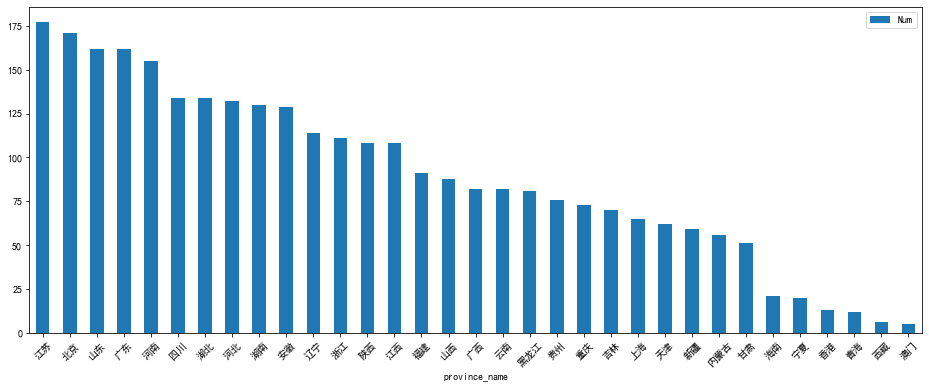

In [11]:
#groupby之后即生成所需图
#使用agg对groupby之后的结果列生成新列名，aggfunc对应使用的聚合函数名称
df.groupby('province_name').agg(Num=pd.NamedAgg(
    column='province_name', aggfunc='count')).reset_index().sort_values(
        by='Num', ascending=False).plot(x='province_name',
                                        y='Num',
                                        kind='bar',
                                        figsize=(16, 6),
                                        rot=45)

In [12]:
df_level = df.groupby([
    'province_name', 'level_name'
]).agg(Num=pd.NamedAgg(column='province_name', aggfunc='count')).sort_values(
    by='Num', ascending=False)

#行转列方式一
#df_leve2 = df_level.unstack()
#行转列方式二
df_level2 = df_level.pivot_table(index = 'province_name', columns = 'level_name', values='Num')
df_level2.head()

level_name,专科（高职）,普通本科
province_name,,
上海,20.00,45.00
云南,50.00,32.00
内蒙古,37.00,19.00
北京,51.00,120.00
吉林,29.00,41.00


### 柱状图：查看人气值前30学校

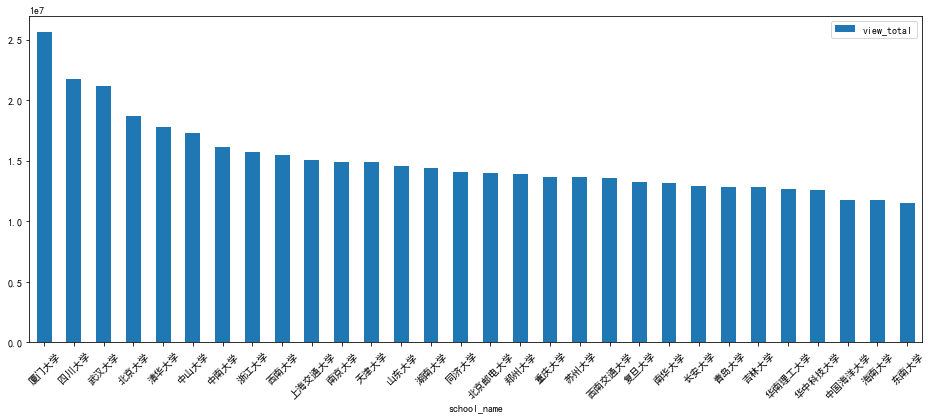

In [13]:
df[['school_name',
    'view_total']].sort_values(by='view_total',
                               ascending=False).head(30).plot(x='school_name',
                                                              y='view_total',
                                                              kind='bar',
                                                              figsize=(16, 6),
                                                              rot=45)

### 堆叠柱状图：各省不同层次学校占比 

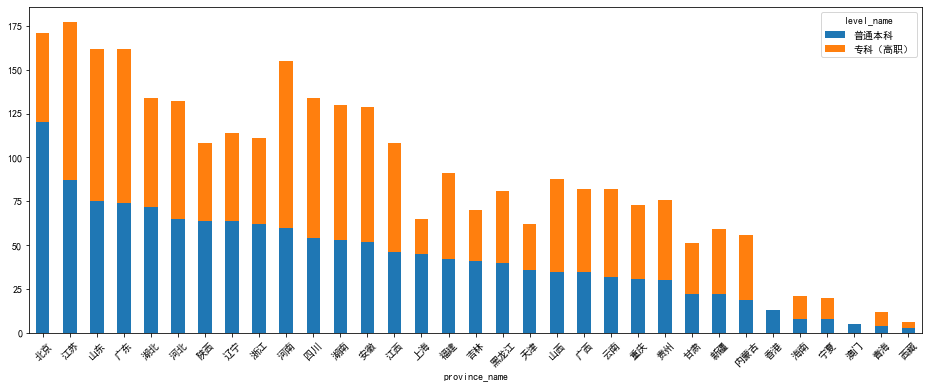

In [14]:
#stacked = True 堆叠
#堆叠图前对df进行处理，需要堆叠的字段转为列
df_level2.sort_values(by='普通本科', ascending=False).plot(y=['普通本科', '专科（高职）'],
                                                       kind='bar',
                                                       figsize=(16, 6),
                                                       rot=45,
                                                       stacked=True)

In [15]:
df_mb1 = df[df['nature_name'] == '民办'].groupby([
    'province_name'
]).agg(Num=pd.NamedAgg(column='province_name', aggfunc='count')).sort_values(
    by='Num', ascending=False)
df_province = df.groupby('province_name').agg(Num=pd.NamedAgg(
    column='province_name', aggfunc='count')).reset_index().sort_values(
        by='Num', ascending=False)
df_mb1 = df_mb1.merge(df_province, on='province_name')
df_mb1.columns = ['province_name', 'mb_num', 'total_num']
df_mb1['rate'] = round(df_mb1['mb_num'] / df_mb1['total_num'], 2)
df_mb1.head()

,province_name,mb_num,total_num,rate
0,江苏,48,177,0.27
1,广东,48,162,0.30
2,四川,47,134,0.35
3,北京,46,171,0.27
4,湖北,42,134,0.31


### 双Y轴组合图： 各省民办学校占比情况

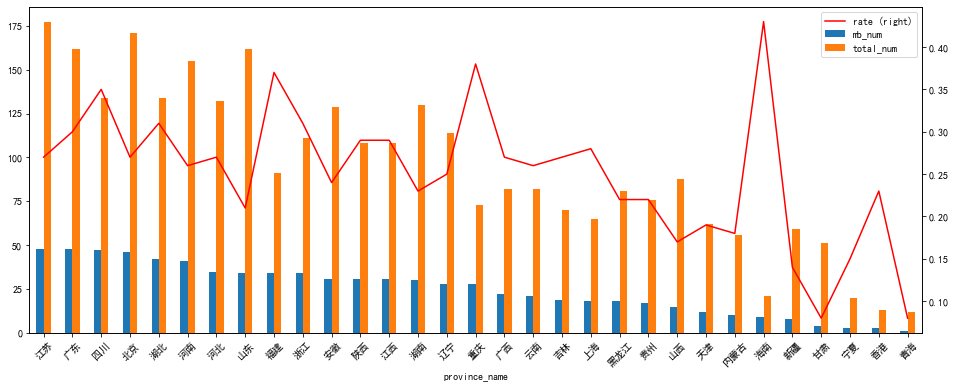

In [16]:
#组合图，原理上是使用ax参数，调用matplolib对象，双Y轴使用secondary_y参数来实现
ax1 = df_mb1[['province_name', 'rate']].plot(x='province_name',
                                 secondary_y=['rate'],
                                 kind='line',
                                 figsize=(16, 8),
                                 color='red',
                                 rot=45)
df_mb1.plot(x='province_name', y=['mb_num','total_num'],kind='bar', ax=ax1, figsize=(16, 6))

### 饼图：专业类占比情况 

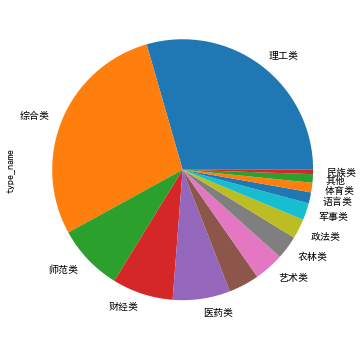

In [17]:
df.groupby('type_name')['type_name'].count().sort_values(ascending=False).plot(
    kind='pie', figsize=(16, 6))